# Download and unzip images

In [ ]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar -zxvf mnist_png.tar.gz

In [ ]:
!tree -Lh 3

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs')

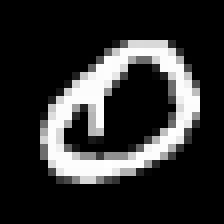

In [18]:
image0 = Image.open('mnist_png/training/0/11105.png')
image0 = image0.resize((image0.width*8, image0.height*8))
image0

In [19]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [20]:
def data_loader(data_type, batch_size):
    data_path = 'mnist_png/'+ data_type + '/'  # data_type = training/testing
    
#    By default the image has 3 channels and we exepect the image to be grayscale.
#    So let's tranform the image to grayscale

    dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        #    By default the imageFolder loads images with 3 channels and we expect the image to be grayscale.
        #    So let's transform the image to grayscale
        transform =  transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        shuffle=True
    )
    return loader

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)        
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128) # 64(no. of channels from conv2)*12*12 = 9216
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):        
        #x.shape = 32, 1, 28, 28 (N=batch size, C=channels, H=height, W=width) . original image is 28x28 px
        x = self.conv1(x) 
        #x.shape = 32, 32, 26, 26
        x = F.relu(x)        
        x = self.conv2(x) 
        # x.shape = 32, 64, 24, 24
        x = F.max_pool2d(x, 2) # stride=2 will reduce the dimesions to half
        # x.shape = 32, 64, 12, 12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # x.shape = 32, 9216
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [43]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            niter = epoch*len(train_loader)+batch_idx
#             writer.add_scalar('Train/Loss', loss.data[0], niter)

In [44]:
def main():
    device = torch.device("cuda")
    
    batch_size = 32
    train_loader = data_loader('training', batch_size )
    test_loader = data_loader('testing', batch_size )
    log_interval=600 # batches
    lr = 1.0
    epochs = 5
    gamma = 0.7
    
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
    for epoch in range(1, epochs + 1):
        train(log_interval, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
    
    torch.save(model.state_dict(), "mnist_cnn.pt")


In [45]:
import time
if __name__ == '__main__':
    start_time = time.time()
    print('starting at: ',time.strftime('%Y-%m-%d %H:%M:%S'))
    main()
    end_time = time.time()
    print('ending  at: ',time.strftime('%Y-%m-%d %H:%M:%S'))
    print('total time taken: ', round(end_time-start_time,2), ' seconds')
    

starting at:  2019-12-26 13:22:22
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301808
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.049540
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.297102
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.032306

Test set: Average loss: 0.0520, Accuracy: 9834/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.110148
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.002803
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.055882
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.019621

Test set: Average loss: 0.0380, Accuracy: 9875/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.028334
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.255309
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.079158
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.023425

Test set: Average loss: 0.0331, Accuracy: 9893/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.047856
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.001571
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.022782
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.168567

Te

Time taken for 5 epochs with num_workers=1, pin_memory=True :  108.68  seconds

 
Time taken for 5 epochs without setting num_workers and pin_memory: 117.45  seconds

